In [1]:
import numpy as np  
import pandas as pd 
import os
import matplotlib.pyplot as plt

import cv2 as cv
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.io.wavfile import read

from tqdm.notebook import tqdm as tqdm

In [2]:
from sklearn.cluster import KMeans 

In [3]:
import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader

In [4]:
TRAIN_PART = 0.05 # part of full data used to train our model 
VAL_PART = 0.2 # part of train data for validation 

In [5]:
train_df = pd.read_csv('/kaggle/input/silero-audio-classifier/train.csv')
_, train_df, _, _ = train_test_split(train_df, train_df['label'].values, test_size = TRAIN_PART, stratify = train_df['label'].values)
train, val, _, _ = train_test_split(train_df, train_df['label'].values, test_size = VAL_PART, stratify = train_df['label'].values)

In [6]:
def to_onehot(label, num_class = 3):
    one_hot = torch.zeros(num_class)
    one_hot[label] = 1
    return one_hot

def read_audio(path):
            sr, wav = read(path)
            assert sr == 16000
            assert len(wav) == 16000 * 3
            assert len(wav.shape) == 1
            return wav
        
def read_audio_norm(path):
            wav = read_audio(path)
            abs_max = np.abs(wav).max()
            wav = wav.astype('float32')
            if abs_max > 0:
                wav *= 1 / abs_max
            return wav

window_size = 0.02
window_stride = 0.01
sample_rate = 16000

n_fft = int(sample_rate * (window_size + 1e-8))
win_length = n_fft
hop_length = int(sample_rate * (window_stride + 1e-8))

kwargs = {
    'n_fft': n_fft,
    'hop_length': hop_length,
    'win_length': n_fft
}

def stft(wav):
    D = librosa.stft(wav,
                     **kwargs)
    mag, phase = librosa.magphase(D)    
    return mag

In [7]:
class SoundDataset(Dataset):
    
    def __init__(self, df, test = False, data_path = '/kaggle/input/silero-audio-classifier/train'):
        super().__init__()
        self.data_path = data_path
        self.df = df
        self.test = test
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
                
        label_dict = {'speech':0,
                      'music':1,
                      'noise':2}
        
        wav = read_audio_norm(os.path.join(self.data_path, self.df.iloc[idx].wav_path))
        stft_im = stft(wav)
        stft_im = cv.resize(stft_im, (256,128))
        mag = torch.tensor(stft_im, dtype = torch.float32).unsqueeze(0)
        
        if not self.test:
            label = self.df.iloc[idx].target #label_dict[self.df.iloc[idx].label]
            label_one_hot = to_onehot(label)
            return mag, label_one_hot, torch.tensor(label, dtype = torch.int)
        
        return mag

In [8]:
pool = nn.AdaptiveAvgPool2d((161,3))

In [9]:
train_dataset = SoundDataset(train)
val_dataset = SoundDataset(val)

train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 128, shuffle = False)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [11]:

train_latent = []
train_labels = []

tkloader = tqdm(train_loader, total = len(train_loader))
for x, _, labels in tkloader:
    x = nn.Flatten()(pool(x)).cpu().detach().numpy()
    train_latent.append(x)
    labels = labels.cpu().detach().numpy()
    train_labels.append(labels)
    
X_train = np.concatenate(train_latent, axis = 0)
Y_train = np.concatenate(train_labels, axis = 0)

  

In [12]:
val_latent = []
val_labels = []

tkloader = tqdm(val_loader, total = len(val_loader))
for x, _, labels in tkloader:
    x = nn.Flatten()(pool(x)).cpu().detach().numpy()
    val_latent.append(x)
    labels = labels.cpu().detach().numpy()
    val_labels.append(labels)

X_val = np.concatenate(val_latent, axis = 0)
Y_val = np.concatenate(val_labels, axis = 0)

In [13]:
'''
sub = pd.read_csv('/kaggle/input/silero-audio-classifier/sample_submission.csv')
test_data_path = '/kaggle/input/silero-audio-classifier/val'
test_dataset = SoundDataset(sub, test=True, data_path = test_data_path)
test_loader = DataLoader(test_dataset, batch_size = 256, shuffle = False)

test_latent = []

tkloader = tqdm(test_loader, total = len(test_loader))
for x in tkloader:
    x = nn.Flatten()(pool(x)).cpu().detach().numpy()
    test_latent.append(x)
    
X_test = np.concatenate(test_latent, axis = 0)
''';

### Check if classification in latent gives an adequate result

In [14]:
from sklearn.svm import SVC

svm = SVC().fit(X_train, Y_train)
svm.score(X_val, Y_val)

0.8252747252747252

## Visualise data with targets

In [15]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X_train_pca = pca.fit(X_train).transform(X_train)
X_val_pca = pca.transform(X_val)

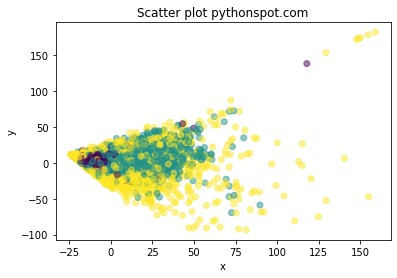

In [16]:
import matplotlib.pyplot as plt


# Plot
plt.scatter(x = X_train_pca[:,0], y = X_train_pca[:,1], c = Y_train,  alpha=0.5)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

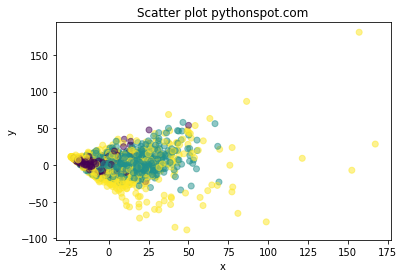

In [17]:
plt.scatter(x = X_val_pca[:,0], y = X_val_pca[:,1], c = Y_val,  alpha=0.5)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## AgglomerativeClustering

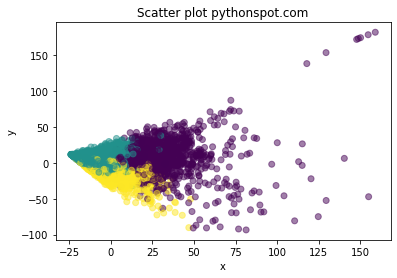

In [18]:
from sklearn.cluster import AgglomerativeClustering, KMeans

cls = AgglomerativeClustering(n_clusters = 3).fit(X_train)
Y_train_pred = cls.labels_

plt.scatter(x = X_train_pca[:,0], y = X_train_pca[:,1], c = Y_train_pred,  alpha=0.5)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

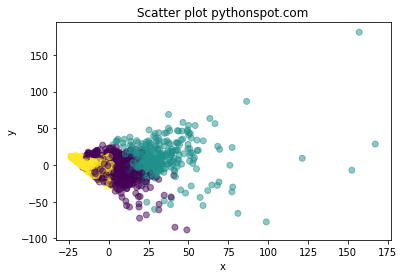

In [19]:
cls = AgglomerativeClustering(n_clusters = 3).fit(X_val)
Y_val_pred = cls.labels_

plt.scatter(x = X_val_pca[:,0], y = X_val_pca[:,1], c = Y_val_pred,  alpha=0.5)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## KMeans

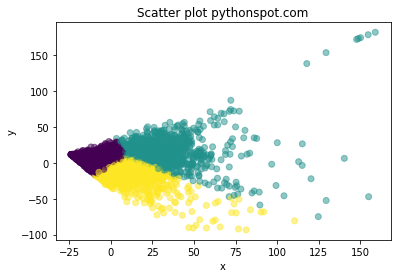

In [20]:
cls = KMeans(n_clusters = 3).fit(X_train)
Y_train_pred = cls.labels_

plt.scatter(x = X_train_pca[:,0], y = X_train_pca[:,1], c = Y_train_pred,  alpha=0.5)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

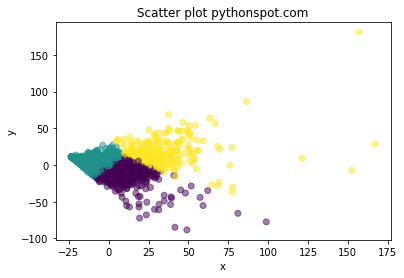

In [21]:
cls = KMeans(n_clusters = 3).fit(X_val)
Y_val_pred = cls.labels_

plt.scatter(x = X_val_pca[:,0], y = X_val_pca[:,1], c = Y_val_pred,  alpha=0.5)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()